In [31]:
import pandas as pd
import numpy as np

# Define file path
file_path = r"C:\Users\parva\OneDrive\Desktop\Paper work\cnofs_ND\TIMED_L2A_SABER_3191544.txt"

# Initialize lists to store parsed data
data = {
    "Time": [],
    "Altitude": [],
    "Latitude": [],
    "Longitude": [],
    "Neutral_Density": [],
    "Tangent_Altitude": []
}

# Open and read file line by line
with open(file_path, 'r') as file:
    for line in file:
        # Split the line by whitespace to separate values
        values = line.strip().split()
        
        # Check if line has at least the minimum number of expected values
        if len(values) >= 405:  # Adjust based on file's column structure
            try:
                # Parse the data into respective lists
                time_value = " ".join(values[0:2])  # Time is the first two entries
                altitude_value = float(values[2])   # Altitude
                latitude_value = float(values[3])   # Latitude
                longitude_value = float(values[4])  # Longitude

                # Extract and handle neutral density values (columns 5 to 404)
                neutral_density_values = [float(v) if v != '-999.00' else np.nan for v in values[5:405]]
                
                # Extract and handle tangent altitude values (columns 405 onward)
                tangent_altitude_values = [float(v) if v != '-999.0' else np.nan for v in values[405:]]

                # Append parsed values only if all required fields are present
                data["Time"].append(time_value)
                data["Altitude"].append(altitude_value)
                data["Latitude"].append(latitude_value)
                data["Longitude"].append(longitude_value)
                data["Neutral_Density"].append(neutral_density_values)
                data["Tangent_Altitude"].append(tangent_altitude_values)

            except ValueError:
                print(f"Warning: Could not parse line: {line}")

# Convert to DataFrame for easy processing
df = pd.DataFrame(data)

# Convert 'Time' column to datetime format
df['Time'] = pd.to_datetime(df['Time'], dayfirst=True, errors='coerce')

# Define the desired latitude and longitude ranges
lat_range = (-90, 18.66)
lon_range = (232, 342)

# Helper function to strictly find the neutral density value at 110 km (within ±0.1 km tolerance)
def get_neutral_density_exact_110(tangent_altitudes, neutral_density):
    try:
        # Find index where tangent altitude is closest to 110 km within ±0.1 tolerance
        closest_index = np.nanargmin(np.abs(np.array(tangent_altitudes) - 110))
        if abs(tangent_altitudes[closest_index] - 110) <= 0.1:
            return neutral_density[closest_index]
        else:
            return np.nan  # Return NaN if no value close to 110 km within tolerance
    except (ValueError, IndexError):
        return np.nan  # Return NaN if there's an error

# Apply filtering for latitude, longitude, and neutral density at 110 km
filtered_data = df[
    (df["Latitude"] >= lat_range[0]) & 
    (df["Latitude"] <= lat_range[1]) & 
    (df["Longitude"] >= lon_range[0]) & 
    (df["Longitude"] <= lon_range[1])
].copy()

# Extract neutral density values strictly at 110 km tangent altitude
filtered_data["Neutral_Density_110km"] = filtered_data.apply(
    lambda row: get_neutral_density_exact_110(row["Tangent_Altitude"], row["Neutral_Density"]),
    axis=1
)

# Drop rows with NaN values in 'Neutral_Density_110km' and ensure no NaT in 'Time'
filtered_data = filtered_data.dropna(subset=["Neutral_Density_110km", "Time"])

# Filter data to include only rows where the month is January
filtered_data = filtered_data[filtered_data['Time'].dt.month == 12]

# Display the final filtered data for January with consistent 110 km neutral density
print("Filtered Data for December:\n", filtered_data[["Time", "Altitude", "Latitude", "Longitude", "Neutral_Density_110km"]])


Filtered Data for December:
                          Time  Altitude  Latitude  Longitude  \
49    2009-12-01 00:51:42.912   633.006 -50.06000    313.741   
59    2009-12-01 01:01:29.280   620.691 -16.20650    314.043   
61    2009-12-01 01:03:22.393   619.321  -9.76868    314.929   
62    2009-12-01 01:04:22.682   618.798  -4.48614    315.499   
63    2009-12-01 01:05:32.644   618.356  -2.41664    316.275   
...                       ...       ...       ...        ...   
40488 2009-12-31 23:38:47.552   618.328  -6.24825    245.236   
40489 2009-12-31 23:39:29.964   618.082  -1.98579    245.677   
40491 2009-12-31 23:41:26.073   617.761   4.47796    247.134   
40493 2009-12-31 23:43:18.789   617.948  10.65000    248.868   
40495 2009-12-31 23:45:29.578   618.734  17.66050    251.350   

       Neutral_Density_110km  
49              1.301500e+12  
59              1.334700e+12  
61              1.435000e+12  
62              1.501900e+12  
63              1.519100e+12  
...             

In [33]:
# Extract the date (without time) from the 'Time' column for grouping
filtered_data['Date'] = filtered_data['Time'].dt.date

# Group by 'Date' and calculate the mean of 'Neutral_Density_110km' for each day
daily_average = filtered_data.groupby('Date')['Neutral_Density_110km'].mean().reset_index()

# Rename columns for clarity
daily_average.columns = ['Date', 'Average_Neutral_Density_110km']

# Display the result
print(daily_average)
# Save the daily average neutral density data to a CSV file
daily_average.to_csv('daily_average_nd_2009_12.csv', index=False)

# Notify that the file has been saved
print("Daily average neutral density data has been saved to 'daily_average_nd_2009_12.csv'")


          Date  Average_Neutral_Density_110km
0   2009-12-01                   1.491603e+12
1   2009-12-02                   1.630700e+12
2   2009-12-04                   1.379196e+12
3   2009-12-05                   1.503059e+12
4   2009-12-06                   1.433862e+12
5   2009-12-07                   1.467158e+12
6   2009-12-08                   1.429571e+12
7   2009-12-09                   1.492641e+12
8   2009-12-10                   1.481777e+12
9   2009-12-11                   1.518014e+12
10  2009-12-12                   1.610407e+12
11  2009-12-13                   1.557889e+12
12  2009-12-14                   1.633071e+12
13  2009-12-15                   1.452248e+12
14  2009-12-16                   1.508798e+12
15  2009-12-17                   1.560519e+12
16  2009-12-18                   1.600975e+12
17  2009-12-19                   1.575901e+12
18  2009-12-20                   1.529595e+12
19  2009-12-21                   1.567919e+12
20  2009-12-22                   1

In [34]:
import pandas as pd
import numpy as np

# Define file path
file_path = r"C:\Users\parva\OneDrive\Desktop\Paper work\cnofs_ND\TIMED_L2A_SABER_484766.txt"

# Initialize lists to store parsed data
data = {
    "Time": [],
    "Altitude": [],
    "Latitude": [],
    "Longitude": [],
    "Neutral_Density": [],
    "Tangent_Altitude": []
}

# Open and read file line by line
with open(file_path, 'r') as file:
    for line in file:
        # Split the line by whitespace to separate values
        values = line.strip().split()
        
        # Check if line has at least the minimum number of expected values
        if len(values) >= 405:  # Adjust based on file's column structure
            try:
                # Parse the data into respective lists
                time_value = " ".join(values[0:2])  # Time is the first two entries
                altitude_value = float(values[2])   # Altitude
                latitude_value = float(values[3])   # Latitude
                longitude_value = float(values[4])  # Longitude

                # Extract and handle neutral density values (columns 5 to 404)
                neutral_density_values = [float(v) if v != '-999.00' else np.nan for v in values[5:405]]
                
                # Extract and handle tangent altitude values (columns 405 onward)
                tangent_altitude_values = [float(v) if v != '-999.0' else np.nan for v in values[405:]]

                # Append parsed values only if all required fields are present
                data["Time"].append(time_value)
                data["Altitude"].append(altitude_value)
                data["Latitude"].append(latitude_value)
                data["Longitude"].append(longitude_value)
                data["Neutral_Density"].append(neutral_density_values)
                data["Tangent_Altitude"].append(tangent_altitude_values)

            except ValueError:
                print(f"Warning: Could not parse line: {line}")

# Convert to DataFrame for easy processing
df = pd.DataFrame(data)

# Convert 'Time' column to datetime format
df['Time'] = pd.to_datetime(df['Time'], dayfirst=True, errors='coerce')

# Define the desired latitude and longitude ranges
lat_range = (-90, 18.66)
lon_range = (232, 342)

# Helper function to strictly find the neutral density value at 110 km (within ±0.1 km tolerance)
def get_neutral_density_exact_110(tangent_altitudes, neutral_density):
    try:
        # Find index where tangent altitude is closest to 110 km within ±0.1 tolerance
        closest_index = np.nanargmin(np.abs(np.array(tangent_altitudes) - 110))
        if abs(tangent_altitudes[closest_index] - 110) <= 0.1:
            return neutral_density[closest_index]
        else:
            return np.nan  # Return NaN if no value close to 110 km within tolerance
    except (ValueError, IndexError):
        return np.nan  # Return NaN if there's an error

# Apply filtering for latitude, longitude, and neutral density at 110 km
filtered_data = df[
    (df["Latitude"] >= lat_range[0]) & 
    (df["Latitude"] <= lat_range[1]) & 
    (df["Longitude"] >= lon_range[0]) & 
    (df["Longitude"] <= lon_range[1])
].copy()

# Extract neutral density values strictly at 110 km tangent altitude
filtered_data["Neutral_Density_110km"] = filtered_data.apply(
    lambda row: get_neutral_density_exact_110(row["Tangent_Altitude"], row["Neutral_Density"]),
    axis=1
)

# Drop rows with NaN values in 'Neutral_Density_110km' and ensure no NaT in 'Time'
filtered_data = filtered_data.dropna(subset=["Neutral_Density_110km", "Time"])

# Filter data to include only rows where the month is January
filtered_data = filtered_data[filtered_data['Time'].dt.month == 2]

# Display the final filtered data for January with consistent 110 km neutral density
print("Filtered Data for February:\n", filtered_data[["Time", "Altitude", "Latitude", "Longitude", "Neutral_Density_110km"]])

Filtered Data for February:
                          Time  Altitude  Latitude  Longitude  \
33    2010-02-01 00:34:20.133   618.949  18.47290    316.292   
36    2010-02-01 00:37:41.226   619.006   8.92216    317.845   
39    2010-02-01 00:40:19.348   620.145  -1.80014    319.610   
40    2010-02-01 00:41:29.914   620.971  -3.86141    320.607   
41    2010-02-01 00:42:11.649   621.522  -7.97471    321.231   
...                       ...       ...       ...        ...   
38507 2010-02-27 22:23:14.470   634.703 -41.18220    298.604   
38513 2010-02-27 22:29:13.803   640.343 -52.24350    321.325   
38583 2010-02-27 23:41:17.796   618.494  18.24400    249.672   
38588 2010-02-27 23:46:32.027   619.242   2.34402    252.453   
38598 2010-02-27 23:56:17.032   629.433 -28.74590    264.553   

       Neutral_Density_110km  
33              1.813300e+12  
36              2.447200e+12  
39              2.202000e+12  
40              2.475000e+12  
41              2.931800e+12  
...             

In [35]:
# Extract the date (without time) from the 'Time' column for grouping
filtered_data['Date'] = filtered_data['Time'].dt.date

# Group by 'Date' and calculate the mean of 'Neutral_Density_110km' for each day
daily_average = filtered_data.groupby('Date')['Neutral_Density_110km'].mean().reset_index()

# Rename columns for clarity
daily_average.columns = ['Date', 'Average_Neutral_Density_110km']

# Display the result
print(daily_average)
# Save the daily average neutral density data to a CSV file
daily_average.to_csv('daily_average_nd_2010_2.csv', index=False)

# Notify that the file has been saved
print("Daily average neutral density data has been saved to 'daily_average_nd_2010_2.csv'")

          Date  Average_Neutral_Density_110km
0   2010-02-01                   1.653080e+12
1   2010-02-02                   1.475457e+12
2   2010-02-03                   1.490790e+12
3   2010-02-04                   1.500516e+12
4   2010-02-05                   1.488668e+12
5   2010-02-06                   1.550924e+12
6   2010-02-07                   1.582581e+12
7   2010-02-08                   1.663772e+12
8   2010-02-09                   1.753511e+12
9   2010-02-10                   1.507300e+12
10  2010-02-11                   1.629763e+12
11  2010-02-12                   1.578260e+12
12  2010-02-13                   1.530515e+12
13  2010-02-14                   1.535468e+12
14  2010-02-15                   1.538165e+12
15  2010-02-16                   1.607872e+12
16  2010-02-17                   1.623401e+12
17  2010-02-18                   1.631370e+12
18  2010-02-19                   1.698741e+12
19  2010-02-20                   1.678568e+12
20  2010-02-21                   1

In [36]:
import pandas as pd
import numpy as np

# Define file path
file_path = r"C:\Users\parva\OneDrive\Desktop\Paper work\cnofs_ND\TIMED_L2A_SABER_551473.txt"

# Initialize lists to store parsed data
data = {
    "Time": [],
    "Altitude": [],
    "Latitude": [],
    "Longitude": [],
    "Neutral_Density": [],
    "Tangent_Altitude": []
}

# Open and read file line by line
with open(file_path, 'r') as file:
    for line in file:
        # Split the line by whitespace to separate values
        values = line.strip().split()
        
        # Check if line has at least the minimum number of expected values
        if len(values) >= 405:  # Adjust based on file's column structure
            try:
                # Parse the data into respective lists
                time_value = " ".join(values[0:2])  # Time is the first two entries
                altitude_value = float(values[2])   # Altitude
                latitude_value = float(values[3])   # Latitude
                longitude_value = float(values[4])  # Longitude

                # Extract and handle neutral density values (columns 5 to 404)
                neutral_density_values = [float(v) if v != '-999.00' else np.nan for v in values[5:405]]
                
                # Extract and handle tangent altitude values (columns 405 onward)
                tangent_altitude_values = [float(v) if v != '-999.0' else np.nan for v in values[405:]]

                # Append parsed values only if all required fields are present
                data["Time"].append(time_value)
                data["Altitude"].append(altitude_value)
                data["Latitude"].append(latitude_value)
                data["Longitude"].append(longitude_value)
                data["Neutral_Density"].append(neutral_density_values)
                data["Tangent_Altitude"].append(tangent_altitude_values)

            except ValueError:
                print(f"Warning: Could not parse line: {line}")

# Convert to DataFrame for easy processing
df = pd.DataFrame(data)

# Convert 'Time' column to datetime format
df['Time'] = pd.to_datetime(df['Time'], dayfirst=True, errors='coerce')

# Define the desired latitude and longitude ranges
lat_range = (-90, 18.66)
lon_range = (232, 342)

# Helper function to strictly find the neutral density value at 110 km (within ±0.1 km tolerance)
def get_neutral_density_exact_110(tangent_altitudes, neutral_density):
    try:
        # Find index where tangent altitude is closest to 110 km within ±0.1 tolerance
        closest_index = np.nanargmin(np.abs(np.array(tangent_altitudes) - 110))
        if abs(tangent_altitudes[closest_index] - 110) <= 0.1:
            return neutral_density[closest_index]
        else:
            return np.nan  # Return NaN if no value close to 110 km within tolerance
    except (ValueError, IndexError):
        return np.nan  # Return NaN if there's an error

# Apply filtering for latitude, longitude, and neutral density at 110 km
filtered_data = df[
    (df["Latitude"] >= lat_range[0]) & 
    (df["Latitude"] <= lat_range[1]) & 
    (df["Longitude"] >= lon_range[0]) & 
    (df["Longitude"] <= lon_range[1])
].copy()

# Extract neutral density values strictly at 110 km tangent altitude
filtered_data["Neutral_Density_110km"] = filtered_data.apply(
    lambda row: get_neutral_density_exact_110(row["Tangent_Altitude"], row["Neutral_Density"]),
    axis=1
)

# Drop rows with NaN values in 'Neutral_Density_110km' and ensure no NaT in 'Time'
filtered_data = filtered_data.dropna(subset=["Neutral_Density_110km", "Time"])

# Filter data to include only rows where the month is January
filtered_data = filtered_data[filtered_data['Time'].dt.month ==1]

# Display the final filtered data for January with consistent 110 km neutral density
print("Filtered Data for January:\n", filtered_data[["Time", "Altitude", "Latitude", "Longitude", "Neutral_Density_110km"]])

Filtered Data for January:
                          Time  Altitude   Latitude  Longitude  \
46    2010-01-01 00:47:45.613   641.097 -76.825100    338.458   
115   2010-01-01 01:57:29.150   620.031  16.442700    338.653   
147   2010-01-01 02:29:21.407   641.937 -84.549300    251.555   
215   2010-01-01 03:37:51.038   619.066   5.727860    317.807   
217   2010-01-01 03:39:43.477   619.124  -0.505526    319.382   
...                       ...       ...        ...        ...   
43431 2010-01-31 12:13:47.446   636.797 -45.347300    250.053   
43447 2010-01-31 12:29:31.165   618.977   0.919156    277.609   
43535 2010-01-31 14:01:28.590   623.391 -15.788400    248.306   
43541 2010-01-31 14:07:10.195   618.870   2.876390    253.535   
43543 2010-01-31 14:09:47.314   618.257  11.747900    255.033   

       Neutral_Density_110km  
46              1.192800e+12  
115             1.556800e+12  
147             1.435200e+12  
215             1.935400e+12  
217             1.816700e+12  
...  

In [37]:
# Extract the date (without time) from the 'Time' column for grouping
filtered_data['Date'] = filtered_data['Time'].dt.date

# Group by 'Date' and calculate the mean of 'Neutral_Density_110km' for each day
daily_average = filtered_data.groupby('Date')['Neutral_Density_110km'].mean().reset_index()

# Rename columns for clarity
daily_average.columns = ['Date', 'Average_Neutral_Density_110km']

# Display the result
print(daily_average)
# Save the daily average neutral density data to a CSV file
daily_average.to_csv('daily_average_nd_2010_1.csv', index=False)

# Notify that the file has been saved
print("Daily average neutral density data has been saved to 'daily_average_nd_2010_1.csv'")

          Date  Average_Neutral_Density_110km
0   2010-01-01                   1.546505e+12
1   2010-01-02                   1.528673e+12
2   2010-01-03                   1.621980e+12
3   2010-01-04                   1.563987e+12
4   2010-01-05                   1.560573e+12
5   2010-01-06                   1.577451e+12
6   2010-01-07                   1.502874e+12
7   2010-01-08                   1.653776e+12
8   2010-01-09                   1.561133e+12
9   2010-01-10                   1.686511e+12
10  2010-01-11                   1.576115e+12
11  2010-01-12                   1.537655e+12
12  2010-01-13                   1.507676e+12
13  2010-01-14                   1.570758e+12
14  2010-01-15                   1.582174e+12
15  2010-01-16                   1.594791e+12
16  2010-01-17                   1.569285e+12
17  2010-01-18                   1.663809e+12
18  2010-01-19                   1.588686e+12
19  2010-01-20                   1.675224e+12
20  2010-01-21                   1

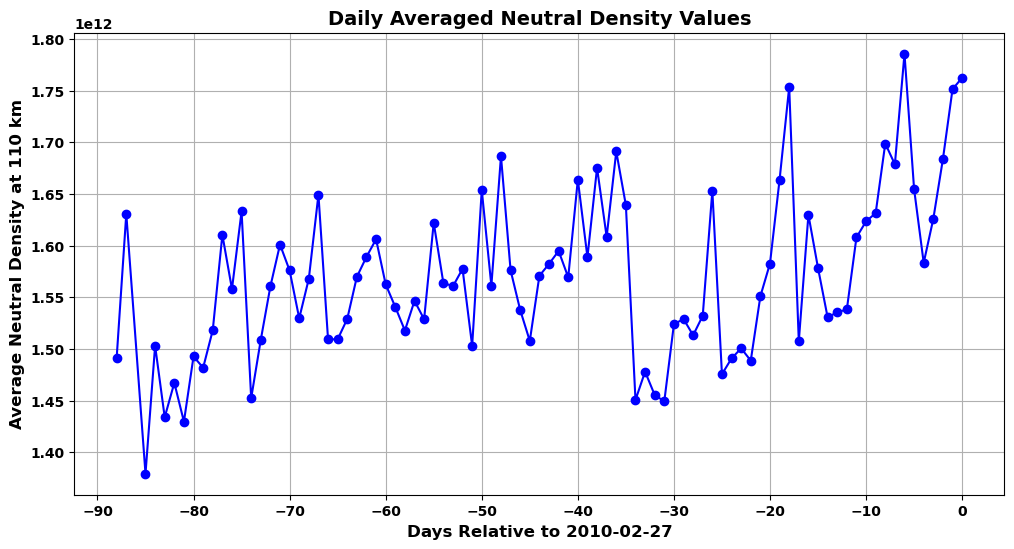

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os
# Define file paths for your three CSV files
file_paths = [
    r"C:\Users\parva\OneDrive\Desktop\Paper work\daily_average_nd_2009_12.csv",
    r"C:\Users\parva\OneDrive\Desktop\Paper work\daily_average_nd_2010_1.csv",
    r"C:\Users\parva\OneDrive\Desktop\Paper work\daily_average_nd_2010_2.csv"
]

# Load and concatenate the CSV files
all_data = [pd.read_csv(file_path) for file_path in file_paths]
combined_df = pd.concat(all_data, ignore_index=True)

# Convert Date column to datetime
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

# Define the end date (February 27, 2010) as day 0
end_date = datetime.strptime("2010-02-27", "%Y-%m-%d")
combined_df['Relative_Day'] = (combined_df['Date'] - end_date).dt.days

# Sort by Relative_Day
combined_df = combined_df.sort_values(by='Relative_Day').reset_index(drop=True)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(combined_df['Relative_Day'], combined_df['Average_Neutral_Density_110km'], color='blue', marker='o')

# Bold settings for title, axis labels, and tick marks
plt.title('Daily Averaged Neutral Density Values', fontweight='bold', fontsize=14)
plt.xlabel('Days Relative to 2010-02-27', fontweight='bold', fontsize=12)
plt.ylabel('Average Neutral Density at 110 km', fontweight='bold', fontsize=12)

# Customize x-axis ticks to show days from -90 to 0 with intervals of 10, and make tick labels bold
plt.xticks(range(-90, 1, 10), fontweight='bold')
plt.yticks(fontweight='bold')  # Make y-axis tick labels bold

# Format y-axis values with scientific notation in bold
plt.ticklabel_format(axis='y', style='sci', scilimits=(12, 12))
ax = plt.gca()
ax.yaxis.get_offset_text().set_fontweight('bold')  # Make the exponent part bold

# Save the figure in the same directory as the input file
directory = os.path.dirname(file_path)
output_path = os.path.join(directory, "neutral_density_plot.png")
plt.savefig(output_path)
plt.grid()
plt.show()
